In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
import math
import matplotlib
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
import keras.backend as K
from keras.models import Sequential
from keras.models import load_model, clone_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, LSTM
from keras.optimizers import Adam
sns.set()

import random
from collections import deque

import numpy as np
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spy-stock-pricecsv/SPY.csv


In [21]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
AAPL = pd.read_csv('/kaggle/input/spy-stock-pricecsv/SPY.csv')
AAPL['Date'] = AAPL['Date'].astype('datetime64[ns]')
AAPL

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,90.790062,118944600
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,91.030411,111579900
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,91.094490,116074400
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,91.479050,131091100
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,91.783432,126402800
...,...,...,...,...,...,...,...
2836,2021-04-12,410.850006,411.929993,410.200012,411.640015,411.640015,56704900
2837,2021-04-13,411.529999,413.529999,411.119995,412.859985,412.859985,56551000
2838,2021-04-14,412.829987,413.959991,410.869995,411.450012,411.450012,61659900
2839,2021-04-15,413.739990,416.160004,413.690002,415.869995,415.869995,60229800


In [22]:
training_data_len = 2667
print('Size of Whole Dataset:', len(AAPL))
test_set = AAPL[training_data_len-60:-1]
print('Size of Test Dataset:', len(test_set))
AAPL = AAPL[0:training_data_len]
print('Size of Training Dataset:', len(AAPL))

Size of Whole Dataset: 2841
Size of Test Dataset: 233
Size of Training Dataset: 2667


### Enviroment

In [23]:
class Env():
    
    # Constructor
    def __init__(self, data, state_length, investment):
        '''
        INPUTS:
        - data [DataFrame]: the dataframe of the stock (from Yahool Finance).
        - state_length [int]: the size of state (trading timeframe) provided to the agent.
        '''
        # State attributes
        self.data = data
        self.state_length = state_length
        
        state = self.data[0:self.state_length].Open
        #state = state.rolling(window=3, center=False).mean()
        self.state = np.array(state).reshape((self.state_length,1))
        
        self.done = False # Whether there is more state
        self.t = self.state_length # Current date where the agent is at
        self.OBSERVATION_SPACE_VALUES = (1,state_length)
        self.ACTION_SPACE_SIZE = 3 # 3 actions avaliable
        
        # Agent attributes
        self.wallet_init = investment # For resetting
        self.wallet = investment # For making updates
        self.portfolio = 0 # Stock owned by agent
        self.action_space = [0, 2] # Assume initial investment can buy at least 1 stock
        
    def step(self, action, deploy=False):
        '''
        INPUTS:
        - action [int]: the action took by the agent. 
            - action = 0: buy
            - action = 1: sell
            - action = 2: hold
        OUTPUTS:
        - state: the new state of the agent (one day foward)
        - reward: the reward of the action
        - action_space: avaliable actions of new state
        '''
        
        # Check if the agent can buy any stock
        # Returns: Boolean. True if can buy, False if not
        def can_buy(self):
            if self.wallet >= self.data.iloc[self.t].Open:
                    return True
            else:
                return False
    
        # Check if the agent can sell any stock
        # Returns: Boolean. True if can sell, False if not
        def can_sell(self):
            if self.portfolio > 0:
                return True
            else:
                return False
        
        # Increment state by 1 step (foward 1 day)
        def step_state(self):
            self.t += 1
            if self.t == self.data.shape[0]-1: # No more data
                self.done = True
            state = self.data[self.t - self.state_length : self.t].Open
            #state = state.rolling(window=3, center=False).mean()
            self.state = np.array(state).reshape((self.state_length,1))
            
        # Find avaliable actions for the next state
        def find_action_space(self):
            action_space = [2] # can always hold
            if can_buy(self):
                action_space.append(0)
            if can_sell(self):
                action_space.append(1)
            self.action_space = action_space
            
        # Computes the total balance: wallet + holdings
        def total_balance(self, price):
            '''
            INPUTS:
            - price [int]: price of 1 stock
            '''
            #current_price = self.data.iloc[0].Open # Price of 1 stock
            return self.wallet + price*self.portfolio
        
        reward = 0 # initialize reward
        price_t1 = self.data.iloc[self.t].Open # Today's price
        step_state(self) # Proceed to next state
        price_t2 = self.data.iloc[self.t].Open # Tomorrow's price
        if action == 0: # buy stock
            self.wallet -= price_t1
            self.portfolio += 1
            # reward is the regret
            reward = 100*(price_t2 - price_t1) / price_t1
        elif action == 1: # sell stock
            self.wallet += price_t1
            self.portfolio -= 1
            # reward is the opportunity cost
            reward = 100*(price_t1 - price_t2) / price_t1
        else: # hold stock
            reward = 0
        find_action_space(self)
        # Agent 'lose the game' if wallet < x% of initial investment or no more data to train
        if deploy == False:
            if (self.wallet+self.portfolio*price_t1) < 0.95*self.wallet_init or self.t >= len(data)-2:
                self.done = True
            else:
                self.done = False
        else:
            if (self.wallet+self.portfolio*price_t1) < self.wallet_init or self.t >= len(data)-2:
                self.done = True
            else:
                self.done = False
        return self.state, reward, self.done
    
    # Reset the environment.
    def reset(self, random_day=False):
        # Reset state attributes
        if random_day == False:
            self.t = self.state_length
            state = self.data[0:self.state_length].Open
            #state = state.rolling(window=3, center=False).mean()
            self.state = np.array(state).reshape((self.state_length,1))
        else: # reset on a random day
            day = np.random.randint(self.state_length,len(self.data))
            self.t = day
            state = self.data[self.t - self.state_length : self.t].Open
            #state = state.rolling(window=3, center=False).mean()
            self.state = np.array(state).reshape((self.state_length,1))
        self.done = False
            
        # Reset agent attributes
        self.wallet = self.wallet_init
        self.portfolio = 0
        self.action_space = [0, 2]
        return self.state

In [24]:
data = AAPL
state_length = 60
investment = 1000
env = Env(data, state_length, investment)

print('Reward:', env.step(1)[1])

AAPL[state_length:state_length+2]

Reward: -0.7268114765321522


,Date,Open,High,Low,Close,Adj Close,Volume
60,2010-03-31,116.949997,117.519997,116.610001,117.000000,94.116142,161078700
61,2010-04-01,117.800003,118.250000,117.099998,117.800003,94.759651,161215200


### Agent

In [25]:
REPLAY_MEMORY = 3_000
MIN_REPLAY_MEMORY_SIZE = 100
MINIBATCH_SIZE = 64
DISCOUNT = 0.99
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)

# Exploration settings
EPISODES = 100 #750
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99
MIN_EPSILON = 0.05

class DQN_agent():
    def __init__(self):
        # Main model: gets trained every step
        self.model = self.create_model()
        # Target model: makes prediction every step
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        # Update target network weights
        self.replay_memory = deque(maxlen=REPLAY_MEMORY)
        # Counter for updating target netowrk weights
        self.target_update_counter = 0
    
    def create_model(self):        
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(60, 1)))
        #model.add(LSTM(128, return_sequences=True, input_shape=env.OBSERVATION_SPACE_VALUES))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))      
        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['accuracy'])
        return model
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
        
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape))[0]
        #return self.model.predict(state)[0]
    
    def train(self, terminal_state, step):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states)
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states)
        X = []
        y = []
        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)
        
        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
    
    def deploy(self, data, investment=1000):
        # Reset environment and get initial state
        buy_sell_signal = [[[],[]],[[],[]]] # 1st arr: Buy history; 2nd arr: sell history. [date, price]
        
        env = Env(data, 60, investment)
        current_state = env.reset(random_day=False)
        done = False
        while not done:
            print('Price:', env.data.iloc[env.t].Open)
            print('wallet:', env.wallet)
            print('portfolio:', env.portfolio)
            qs = agent.get_qs(current_state)
            print('q values:', qs)
            action = np.argmax(qs)
            print('action space', env.action_space)
            print('action:', action)
            if action in env.action_space:
                price = env.data.iloc[env.t].Open
                date = env.data.iloc[env.t].Date
                print('Date:', date)
                if action == 0: # Buy signal
                    buy_sell_signal[0][0].append(date)
                    buy_sell_signal[0][1].append(price)
                elif action == 1: # Sell signal
                    buy_sell_signal[1][0].append(date)
                    buy_sell_signal[1][1].append(price)
            else:
                action = 2 # hold
            current_state, reward, done = env.step(action, deploy=True)
            print()
        return buy_sell_signal

In [27]:
epsilon = 1
played_days = []
exploit_percent = []
actions = []
episode_rewards = []

data = AAPL
state_length = 60
investment = 1000
env = Env(data, state_length, investment)
agent = DQN_agent()

# Iterate over episodes
for episode in range(EPISODES):
    print('Episode:', episode)
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset(random_day=False)
    #current_state = np.array(current_state).reshape((60,1))

    # Reset flag and start iterating until episode ends
    done = False
    
    i = 0
    j = 0
    while not done:
        i += 1
        #print('Action Space:', env.action_space)
        if np.random.random() > epsilon:
            # Get action from Q table
            qs = agent.get_qs(current_state)
            action = np.argmax(qs)
            j += 1
            if action not in env.action_space:
                action = 2 # hold
        else:
            # Get random action
            action = np.random.choice(env.action_space)
        new_state, reward, done = env.step(action)
        
        # Debug
        actions.append(action)
        #print(env.state[0:2])
        #print('Action:', action,'Step reward', reward)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1
    # DEBUG
    print('Episode Reward:', episode_reward)
    episode_rewards.append(episode_reward)
    print('Agent played:', i, 'days')
    played_days.append(i)
    print('Exploit:', 100*j/i, '%')
    exploit_percent.append(100*j/i)

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
    print('Epsilon:', epsilon)
    print()

Episode: 0
Episode Reward: -13.217037806749941
Agent played: 37 days
Exploit: 0.0 %
Epsilon: 0.99

Episode: 1
Episode Reward: -9.34791870279088
Agent played: 2605 days
Exploit: 1.0748560460652592 %
Epsilon: 0.9801

Episode: 2
Episode Reward: -3.1214309814113532
Agent played: 37 days
Exploit: 2.7027027027027026 %
Epsilon: 0.9702989999999999

Episode: 3
Episode Reward: -0.8649499986477037
Agent played: 64 days
Exploit: 1.5625 %
Epsilon: 0.96059601

Episode: 4
Episode Reward: 2.3987904248528693
Agent played: 27 days
Exploit: 3.7037037037037037 %
Epsilon: 0.9509900498999999

Episode: 5
Episode Reward: 8.657381565893976
Agent played: 36 days
Exploit: 8.333333333333334 %
Epsilon: 0.9414801494009999

Episode: 6
Episode Reward: -1.63881427575118
Agent played: 36 days
Exploit: 8.333333333333334 %
Epsilon: 0.9320653479069899

Episode: 7
Episode Reward: -7.89707953397879
Agent played: 36 days
Exploit: 8.333333333333334 %
Epsilon: 0.92274469442792

Episode: 8
Episode Reward: -6.4991835925587695
Ag

### Visualize Training Process

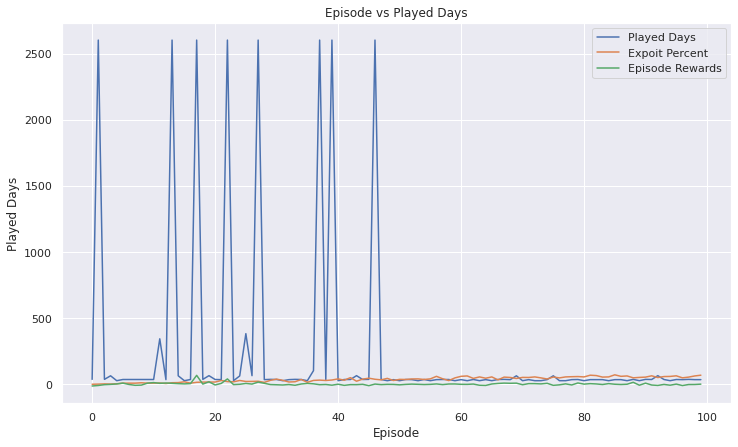

In [28]:
plt.figure(figsize=(12, 7))
plt.plot(played_days, label='Played Days')
plt.plot(exploit_percent, label='Expoit Percent')
plt.plot(episode_rewards, label='Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Played Days')
plt.title('Episode vs Played Days')
plt.legend()

Text(0.5, 1.0, 'Actions Distribution')

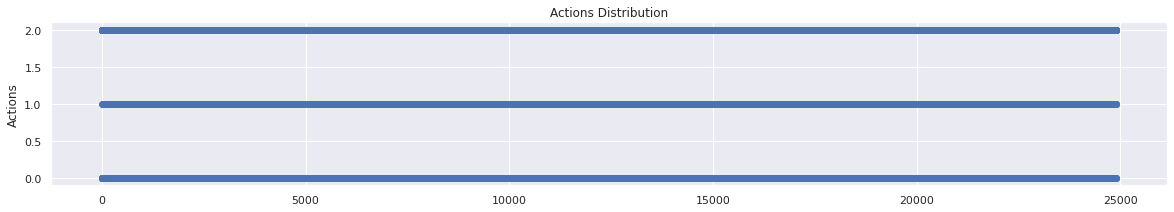

In [29]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(len(actions)), actions, label='actions')
plt.ylabel('Actions')
plt.title('Actions Distribution')

### Deployment

In [30]:
# Deploy the model
buy_info, sell_info = agent.deploy(test_set, investment=10000)

# Visualize buy and sell signals
plt.figure(figsize=(15,10))
plt.plot(data[['Date']], data[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(agent.all_hist[0], agent.all_hist[1], label='Prediction')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

Price: 333.27999900000003
wallet: 10000
portfolio: 0
q values: [0.8281765 0.9142472 0.8894817]
action space [0, 2]
action: 1

Price: 335.059998
wallet: 10000
portfolio: 0
q values: [0.8281765 0.9142472 0.8894817]
action space [2, 0]
action: 1

Price: 336.850006
wallet: 10000
portfolio: 0
q values: [0.8281765 0.9142472 0.8894817]
action space [2, 0]
action: 1

Price: 335.440002
wallet: 10000
portfolio: 0
q values: [0.8281765 0.9142472 0.8894817]
action space [2, 0]
action: 1

Price: 336.609985
wallet: 10000
portfolio: 0
q values: [0.8281765 0.9142472 0.8894817]
action space [2, 0]
action: 1

Price: 336.410004
wallet: 10000
portfolio: 0
q values: [0.8281765 0.9142472 0.8894817]
action space [2, 0]
action: 1

Price: 337.940002
wallet: 10000
portfolio: 0
q values: [0.8281765 0.9142472 0.8894817]
action space [2, 0]
action: 1

Price: 338.339996
wallet: 10000
portfolio: 0
q values: [0.8281765 0.9142472 0.8894817]
action space [2, 0]
action: 1

Price: 339.049988
wallet: 10000
portfolio: 0
q v

IndexError: single positional indexer is out-of-bounds

In [15]:
env.wallet+env.portfolio*test_set.iloc[-1].Open

2166.139955

In [16]:
env.portfolio

4

In [19]:
test_set.iloc[-1].Open*9+6971.02002

10694.67993